# Visualization and inspection
* Visualize importances, globally, locally.
* Trace influential variables to input clusters.
* Scatter influential variables against y
* Plot shap contributions to y = f(x)

In [1]:
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import shap
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.models import HybridExceedenceModel
from Weave.inspection import ImportanceData, MapInterface, data_for_shapplot, yplot, dotplot, barplot, mapplot, scatterplot
#logging.basicConfig(level = logging.DEBUG)
shap.initjs()

In [2]:
basepath = Path('/nobackup_1/users/straaten/')
#basepath = Path('/scistor/ivm/jsn295/')
# Latest results:
quantile = 0.8 # options: 0.666 and 0.8
permimppath = basepath / f'permimp_val_q0{str(quantile)[2:]}'
shappath = basepath / f'shap_stdback_val_q0{str(quantile)[2:]}'
#shappath = basepath / f'shap_pathdep_val_q0{str(quantile)[2:]}'
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 
anompath = basepath / 'processed'

## Amount of input clusters
Independent of the response aggregation. Just dependent on the moment in time before the separation starts.

In [9]:
Xin = pd.read_parquet(inputpath / 'precursor.multiagg.parquet') # All are double because both spatcov and mean was extracted
Xin = Xin.loc[:, Xin.columns.get_loc_level('spatcov','metric')[0]].iloc[-1,:] # Only one timeslice needed.

In [17]:
counts.loc[('sst_nhplus',31,-46)]

separation  metric 
-15         spatcov    2.0
Name: 2019-08-31 00:00:00, dtype: float64

In [22]:
groups = list(Xin.index.names)
groups.remove('clustid')
counts = Xin.groupby(groups).count()
# neccessary for the new cv-approach. To average over folds
groups.remove('fold')
counts = counts.groupby(groups).mean()
counts.index = pd.MultiIndex.from_frame(counts.index.to_frame().assign(respagg = 7)) # To make sure that a unique respagg is present such that non-unique separation becomes the x-var 
counts.name = 'mean_number_of_clusters_over_folds'

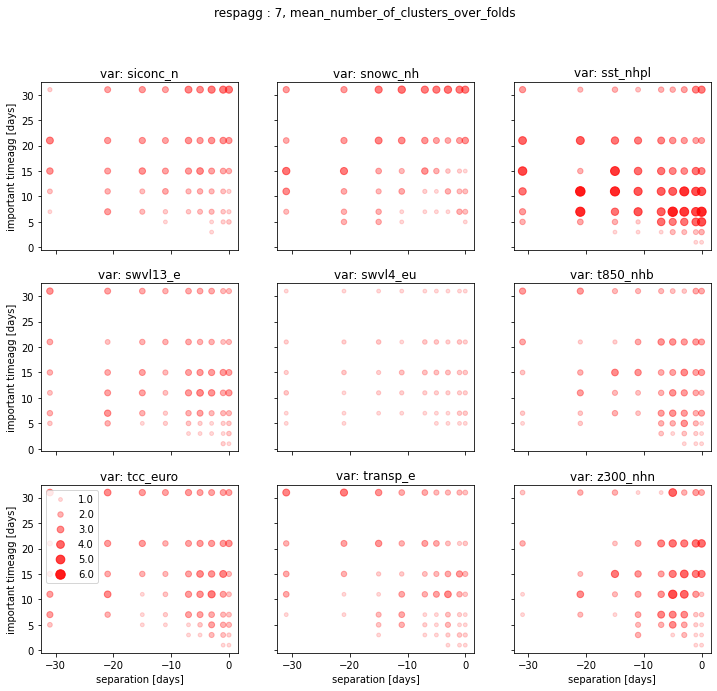

In [23]:
fig, axes = dotplot(counts, alphascaler = 0.15, nlegend_items=6, sizescaler=15)

## Importance of input

In [6]:
respagg_of_interest = [7] # [0,1,3,5,7,11,15,21,31]
separation_of_interest = [0,-1,-3,-5,-7,-11,-15,-21,-31] # -15
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)

Shap specific

In [16]:
shaps = ImportanceData(shappath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
shaps.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaps.global_shap() # Reduces the column (time) axis.
shaps.reduce_over('metric', how = 'max')
shaps.reduce_over('clustid', how = 'mean') # Now max and or sum are doable (we have made absolute the large negative probabilistic influences)
shaps.reduce_over('fold', how = 'mean') # Reduce over the folds.

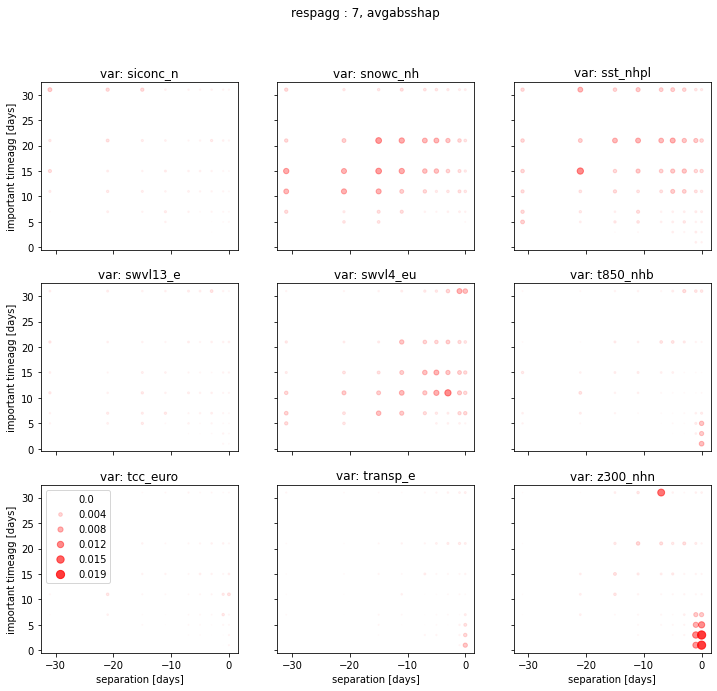

In [20]:
fig, axes = dotplot(shaps.df.iloc[:,0], alphascaler = 40, sizescaler=3500, nlegend_items=6)

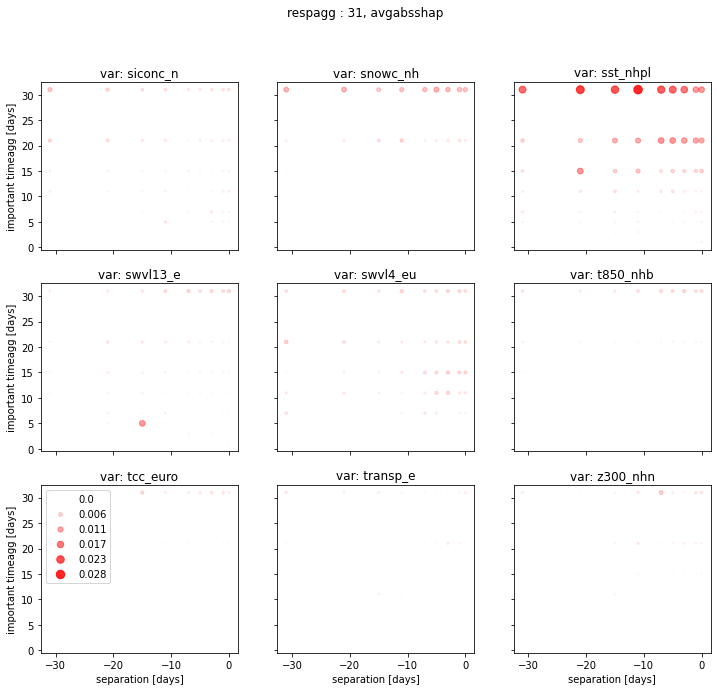

In [14]:
fig, axes = dotplot(shaps.df.iloc[:,0], alphascaler = 30, sizescaler=2500, nlegend_items=6)

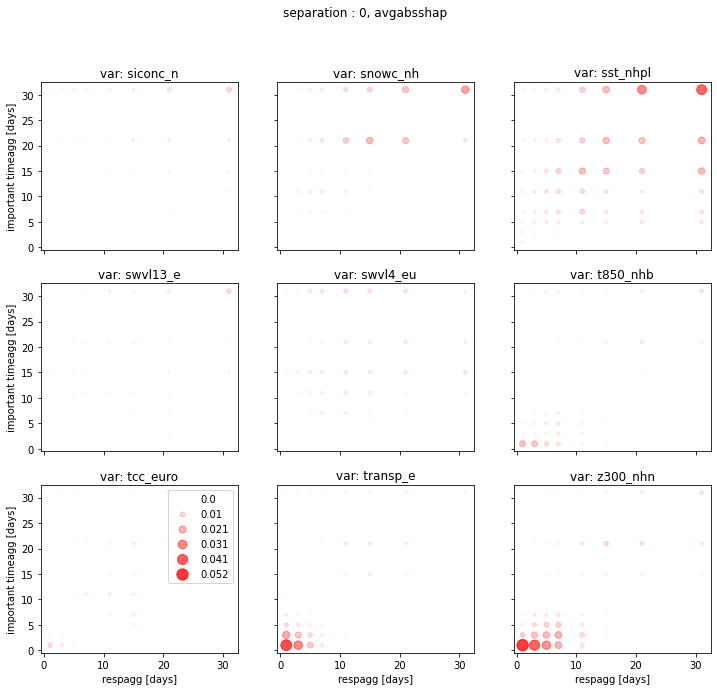

In [6]:
fig, axes = dotplot(shaps.df.iloc[:,0], alphascaler = 15, sizescaler=2500, nlegend_items=6)

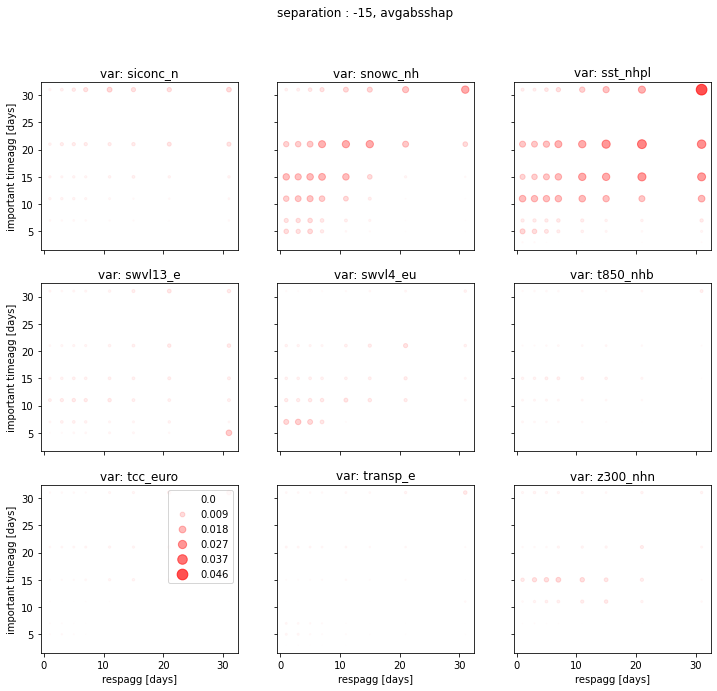

In [9]:
fig, axes = dotplot(shaps.df.iloc[:,0], alphascaler = 15, sizescaler=2500, nlegend_items=6)

Shaps basically show more divergence in importance between the separations and between variables. There is no normalization per prediction situations. It is actual probabilistic impact (not a rank of it) and impact will be larger for the most confident prediction situations. 

At respagg 31 there is some role for swvl and snow cover. But not that much over all data. With max per fold the effect changes a bit. Transpiration, tcc, t850, z300 lack in impact.

permutation importance specific

In [3]:
permimps = ImportanceData(permimppath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
perm.load_data(inputpath = inputpath, X_too = True, y_too = True)
perm.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]
perm.reduce_over('clustid', how = 'max') # Max does not equal sum here. Though it is similar in character (there are no negative importances)
perm.reduce_over('metric', how = 'max')
#perm.df = perm.df.iloc[perm.df.index.get_loc_level('spatcov',level = 'metric')[0],:] # Selecting only one metric
perm.reduce_over('fold', how = 'mean') # Mean equals sum here because the amount of folds is equal.

NameError: name 'respagg_of_interest' is not defined

In [ ]:
fig, axes = dotplot(perm.df.iloc[:,2], alphascaler = 1, nlegend_items=6)

### Look at most important per fold and map to regions

In [4]:
mapint = MapInterface(corclustpath=inputpath)
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)

In [5]:
shaps = ImportanceData(shappath, respagg=31, separation= [-15], quantile = quantile, model=model)
shaps.load_data(inputpath = inputpath)
shaps.global_shap() # Reduces the column axis.

(<Figure size 288x288 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'avgabsshap'}>]], dtype=object))

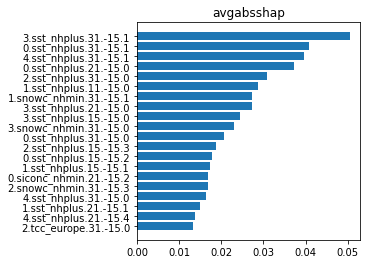

In [6]:
barplot(shaps.df.loc[([31],)],n_most_important=20)

[0.0012910087364388513, 0.0025527091275667387, 0.00023949586357537717, 0.0007886761373579782, 0.000311384297394448] [0.0012910087364388513, 0.0025527091275667387, 0.0009340093095993079, 0.006506962936036903, 0.0008805314540246401]


Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


(<Figure size 864x504 with 11 Axes>,
 array([[<AxesSubplot:title={'center':'fold = 0, separation = -15, timeagg = 31'}, ylabel="(0, 't850_nhblock', 31, -15)">,
         <AxesSubplot:title={'center':'fold = 1, separation = -15, timeagg = 31'}>,
         <AxesSubplot:title={'center':'fold = 2, separation = -15, timeagg = 31'}>],
        [<AxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}, ylabel="(3, 't850_nhblock', 31, -15)">,
         <AxesSubplot:title={'center':'fold = 4, separation = -15, timeagg = 31'}>,
         <AxesSubplot:>]], dtype=object))

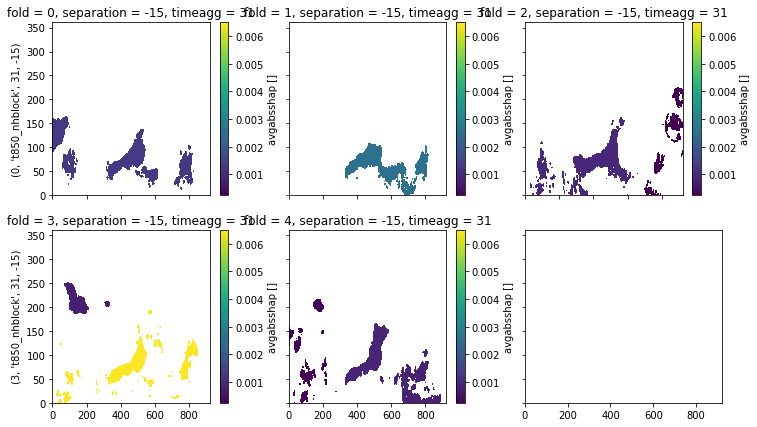

In [8]:
mapresult = mapint.map_to_fields(impdata = shaps, imp = shaps.df.loc[(31,slice(None),'t850_nhblock',31,slice(None),-15,slice(None),'mean'),:].iloc[:,0])
mapplot(mapresult, wrap_per_row=3, match_scales = True)

Now lets project the sst shap values at -21 for a sample. Reload the data because previously we reduced

In [ ]:
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
imps = shap.df.sort_index(axis = 1).loc[(slice(None),'sst_nhplus',slice(None),slice(None),-21),(slice(None),'2003-07-31')]
imps.columns = imps.columns.droplevel(0)
mapresult = mapint.map_to_fields(imps.iloc[:,0])
mapplot(mapresult, wrap_per_row=3)

1 and 3 day differ greatly in impact and clustering. Lets look what the sst anomalies pattern for them looked like

In [ ]:
mapresult = mapint.get_anoms(imps.loc[(slice(None),slice(None),[3,15]),:], mask_with_clustid=False)
mapplot(mapresult)

In [57]:
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
imps = shap.df.sort_index(axis = 1).loc[:,(slice(None),'2003-07-31')].iloc[:,0]

In [69]:
imps2, oldnames = collapse_restore_multiindex(imps,axis = 0, ignore_level = ['respagg','lag','metric'])
imps2 = imps2.sort_values(ascending=False)

In [ ]:
fig,ax = plt.subplots()
ax.barh(range(10), imps2.iloc[:10])
ax.set_yticks(range(10))
ax.set_yticklabels(imps2.index[:10])
plt.show()

In [3]:
impdf = perm.df.iloc[perm.df.index.get_loc_level(5, 'respagg')[0],:3]

In [ ]:
barplot(impdf)

### Visualizing the number of significant cells
To test the effect of the new partial correlation and significance setup in terms of value and number of cells per variable and such

In [56]:
mapint_par = MapInterface(corclustpath=Path('/scistor/ivm/jsn295/non_cv/correlation_roll_spearman_varalpha/'))
mapint_par.cache_everything()

In [57]:
results = []
for variable in mapint_par.presentvars:
    array = getattr(mapint_par, variable)['correlation']
    n_signif = array.count(['latitude','longitude']).to_dataframe()
    n_signif['n'] = len(array.coords['latitude']) * len(array.coords['latitude'])
    n_signif['max'] = float(array.max())
    n_signif['min'] = float(array.min())
    results.append(n_signif)
results = pd.concat(results, keys = pd.Index(mapint_par.presentvars, name = 'variable'), axis = 0)
results['frac'] = results['correlation'] / results['n']

In [ ]:
timeaggs = [31,21,15,5,1]
fold = None # 1.0
fig, axes = plt.subplots(nrows = 1, ncols = len(timeaggs), sharex = True, sharey = True, figsize = (15,3.5), squeeze = True)
for i, timeagg in enumerate(timeaggs):
    ax = axes[i]
    if not fold is None:
        frame = results.loc[(slice(None),timeagg,slice(None),fold),'frac'].unstack('variable')
    else:
        frame = results.loc[(slice(None),timeagg,slice(None)),'frac'].unstack('variable')
    ax.plot(frame.index.get_level_values('separation'), frame.values)
    ax.set_title(f'timeagg: {timeagg}')
    ax.set_xlabel('separation [days]')
    if i == 0:
        ax.set_ylabel('fraction significant cells')
    if i == (len(timeaggs) - 1):
        ax.legend(frame.columns.values)

### Testing scatterplot of X vs y

In [2]:
shap = ImportanceData(basepath = Path('/scistor/ivm/jsn295/shap_standard_val_q08/'), respagg = 31, separation = [0,-1,-3,-5,-7,-11,-15,-21,-31])
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/'), X_too = True, y_too = True) # This second path is for the x-variable

In [3]:
shap.global_shap()

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab8540a390>]],
       dtype=object))

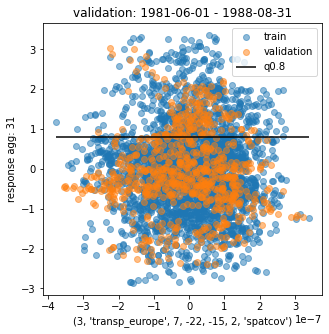

In [6]:
scatterplot(shap, shap.df.iloc[[shap.df.iloc[:,0].argmin()],:], quantile = 0.8)

In [5]:
shap.X

time                                                     1981-06-01  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.031274   
                                                spatcov   -0.303251   
                                        1       mean       3.877896   
                                                spatcov   -0.906956   
2    snowc_nhmin 31      -62 -31        0       mean       4.989387   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.002708   
                                        1       mean       0.010667   
                                                spatcov    0.001023   
                                        2       mean       0.025337   
                                                spatcov    0.000099   

time                                                     1981-06-02  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.273802   
                                                spatcov   -0.336797   
                                        1       mean       4.009231   
                                                spatcov   -0.933497   
2    snowc_nhmin 31      -62 -31        0       mean       5.324197   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001682   
                                        1       mean       0.002889   
                                                spatcov    0.000932   
                                        2       mean       0.027256   
                                                spatcov    0.000105   

time                                                     1981-06-03  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.446171   
                                                spatcov   -0.364802   
                                        1       mean       4.118871   
                                                spatcov   -0.949060   
2    snowc_nhmin 31      -62 -31        0       mean       5.648336   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001397   
                                        1       mean      -0.008257   
                                                spatcov    0.000955   
                                        2       mean       0.030068   
                                                spatcov   -0.000005   

time                                                     1981-06-04  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.532743   
                                                spatcov   -0.384611   
                                        1       mean       4.220785   
                                                spatcov   -0.958956   
2    snowc_nhmin 31      -62 -31        0       mean       5.960511   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001535   
                                        1       mean      -0.017310   
                                                spatcov    0.000842   
                                        2       mean       0.028210   
                                                spatcov   -0.000075   

time                                                     1981-06-05  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.529200   
                                                spatcov   -0.395107   
                    

In [2]:
perm = ImportanceData(Path('/scistor/ivm/jsn295/permimp_val_q0666/'), respagg = 31, separation = -15)
perm.load_data(inputpath = Path('/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/'), X_too = True, y_too = True)
perm.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]

(<Figure size 288x288 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab7b8ceeb8>]],
       dtype=object))

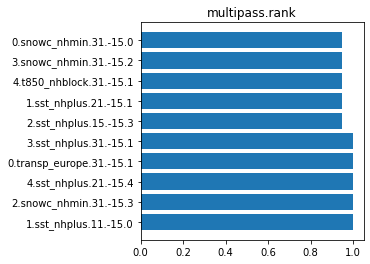

In [3]:
barplot(perm.df.iloc[:,2])

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab7fe89748>]],
       dtype=object))

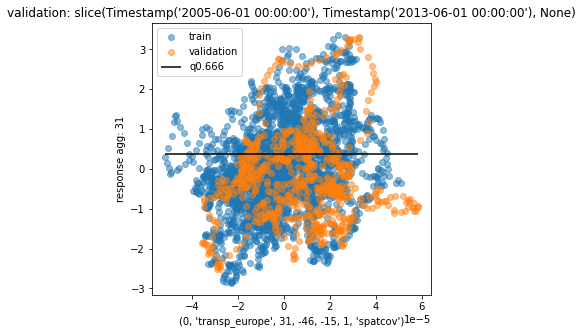

In [5]:
scatterplot(perm, perm.df.iloc[[perm.df.iloc[:,2].argmax()],:], quantile = 0.666)

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab850c3160>]],
       dtype=object))

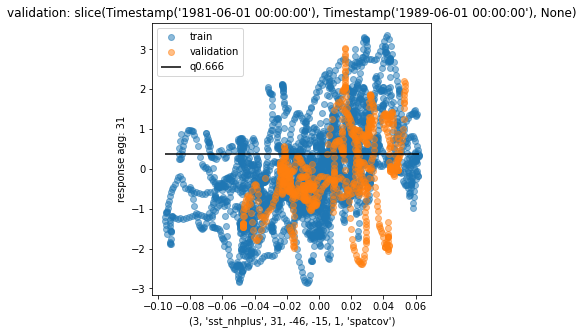

In [13]:
scatterplot(perm, perm.df.loc[([31],[3],['sst_nhplus'],[31],slice(None),slice(None),[1]),:], quantile = 0.666)

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab7b8fca90>]],
       dtype=object))

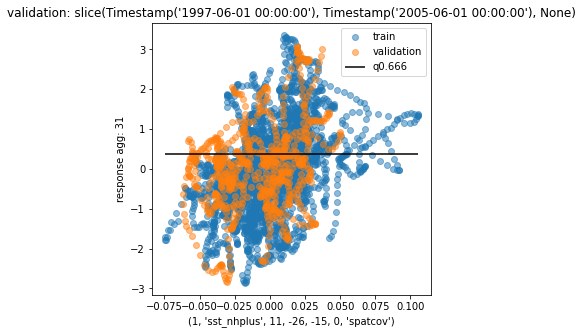

In [14]:
scatterplot(perm, perm.df.loc[([31],[1],['sst_nhplus'],[11],slice(None),[-15],[0]),:], quantile = 0.666)